## Ito current
***Written by: Akwasi Darkwah Akwaboah***<br>
***19/01/2020***

Cordeiro et al adjustment: $V_{1/2} = -41.1\pm 0.2mV$, $k = 6.68\pm 0.19$

***Implement Voltage clamp protocol***

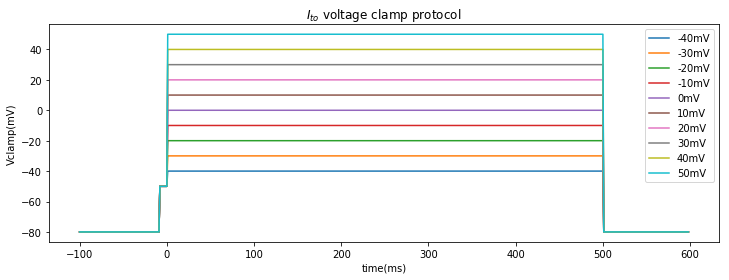

In [2]:
import numpy as np
import matplotlib.pyplot as plt

Vcm = np.arange(-40, 51, 10)    # mV, Command Voltage
Vh_pre = -80    # mV,prepulse Holding Voltage
Vh_brief = -50 #mV
Vh_post = -80   # mV post holding
dt = 1  # time step
tStart = -100
tEnd = 600
nStep = np.int(np.ceil((tEnd - tStart) / dt))  # number of steps
Vm = np.zeros((nStep + 1, 1), dtype=np.float)
plot_time = np.empty((nStep, 1), dtype=np.float)
plot_Vm = np.empty((nStep, len(Vcm)), dtype=np.float)
t = np.linspace(tStart, tEnd, nStep + 1)
i = 0  #column selector

for Vc in Vcm:
    tNow = tStart
    Vm[0] = Vh_pre
    for iStep in np.arange(nStep):
            Vm[iStep+1] = (-10 < tNow < 0.0)* Vh_brief + (tNow <= -10)*Vh_pre + (0.0 <= tNow < 500.0) * Vc +  (tNow >= 500.0) * Vh_post
            plot_Vm[iStep, i] = Vm[iStep]
            plot_time[iStep] = tNow
            tNow = tStart + iStep * dt
    i = i + 1 #increment to next clamp column

plt.figure(figsize = (12,4))
plt.plot(plot_time, plot_Vm)
plt.xlabel('time(ms)')
plt.ylabel('Vclamp(mV)')
plt.title('$I_{to}$ voltage clamp protocol')
plt.legend(['-40mV', '-30mV', '-20mV', '-10mV', '0mV', '10mV', '20mV', '30mV', '40mV', '50mV'], loc='best')

#plt.grid()
plt.show()

***Ito function call - long and short zoomed time course - iniital model w/ cordeiro et al. adjustment***

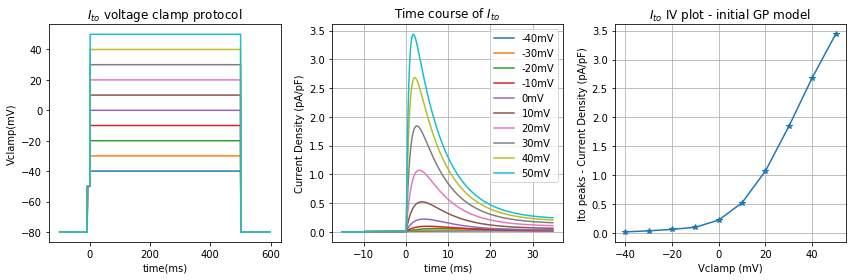

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import timeit

timer_start = timeit.default_timer()

def Ito_func(Gtof, Gtos, xtoss_a, xtoss_b, tx_af, tx_bf, tx_cf, tx_df, ty_af, ty_bf, ty_cf, ty_df,
             tx_as, tx_bs, tx_cs, tx_ds, ty_as, ty_bs, ty_cs, ty_ds):
    
    
    Vcm = np.arange(-40, 51, 10)    # mV, Command Voltage
    Vh_pre = -80    # mV,prepulse Holding Voltage
    Vh_brief = -50 #mV
    Vh_post = -80   # mV post holding
    dt = 0.1  # time step
    tStart = -15
    tEnd = 600.0
    nStep = np.int(np.ceil((tEnd - tStart) / dt))  # number of steps
    # Store the state variables
    
    #xtos = 0.044245060085 #initial condition

    Vm = np.zeros((nStep + 1, 1), dtype=np.float)
    
    plot_xtof = np.zeros((nStep, len(Vcm)), dtype=np.float)
    plot_ytof = np.zeros((nStep, len(Vcm)), dtype=np.float)
    plot_xtos = np.zeros((nStep, len(Vcm)), dtype=np.float)
    plot_ytos = np.zeros((nStep, len(Vcm)), dtype=np.float)
    
    plot_tau_xf = np.zeros((nStep, len(Vcm)), dtype=np.float)
    plot_tau_yf = np.zeros((nStep, len(Vcm)), dtype=np.float)
    plot_tau_xs = np.zeros((nStep, len(Vcm)), dtype=np.float)
    plot_tau_ys = np.zeros((nStep, len(Vcm)), dtype=np.float)
    
    plot_Ito = np.zeros((nStep, len(Vcm)), dtype=np.float)
    plot_time = np.empty((nStep, 1), dtype=np.float)
    plot_Im = np.empty((nStep, len(Vcm)), dtype=np.float)

    t = np.linspace(tStart, tEnd, nStep + 1)
    i = 0  #column selector

    for Vc in Vcm:
        tNow = tStart
        Vm[0] = Vh_pre
        # initial condition
        xtof = 0.001329874225
        ytof = 0.947695521609
        xtos = 0.004100000000
        ytos = 0.994600000000

        EK = -82.8  # mV, Potassium Nernst potential
        Cmem = 1.38e-10  # todo: Cmem value in appropriate orders
        for iStep in np.arange(nStep):
            Vm[iStep+1] = (-10 < tNow < 0.0)* Vh_brief + (tNow <= -10)*Vh_pre + (0.0 <= tNow < 500.0) * Vc +  (tNow >= 500.0) * Vh_post
            xtoss = 1 / (1 + np.exp(-(Vm[iStep] - xtoss_a) / xtoss_b))
            ytoss = 1 / (1 + np.exp((Vm[iStep] + 41.1) / 6.68))
            
            #fast Ito
            tau_xf = tx_af*(np.exp(-((Vm[iStep]+tx_bf)/tx_cf)**2)) + tx_df
            tau_yf = ty_af*(np.exp(-((Vm[iStep]+ty_bf)**2)/ty_cf)) + ty_df
            dxtof = ((xtoss - xtof)/ tau_xf)*dt
            dytof = ((ytoss - ytof)/ tau_yf)*dt
            Itof = Gtof * xtof * ytof * (Vm[iStep] - EK)
            
            #slow Ito
            tau_xs = tx_as/(1+np.exp((Vm[iStep]+tx_bs)/tx_cs)) + tx_ds
            tau_ys = ty_as/(1+np.exp((Vm[iStep]+ty_bs)/ty_cs)) + ty_ds
            dxtos = ((xtoss - xtos)/ tau_xs)*dt
            dytos = ((ytoss - ytos)/ tau_ys)*dt
            Itos = Gtos * xtos * ytos * (Vm[iStep] - EK)
            
            Ito = Itof + Itos
            
            Im = Ito + Cmem*((Vm[iStep+1] - Vm[iStep]) / (t[iStep+1] - t[iStep]))

            plot_xtof[iStep, i] = xtof
            plot_ytof[iStep, i] = ytof
            plot_tau_xf[iStep, i] = tau_xf
            plot_tau_yf[iStep, i] = tau_yf
            plot_tau_xs[iStep, i] = tau_xs
            plot_tau_ys[iStep, i] = tau_ys
            plot_Ito[iStep, i] = Ito
            plot_Im[iStep, i] = Im
            plot_time[iStep] = tNow
            xtof = xtof+dxtof
            ytof = ytof+dytof
            xtos = xtos+dxtos
            ytos = ytos+dytos
            
            tNow = tStart + iStep * dt
        i = i + 1
#     timer_stop = timeit.default_timer()
#     print('Runtime: ', (timer_stop - timer_start)/60.0, 'mins')
    Ito_peaks = np.max(plot_Ito, axis=0)
    # plt.figure()
    # plt.plot(Vcm, Ito_peaks, '-*', Vcm, Ito_exp, '-o')
    # plt.legend(['model', 'exp'])
    # plt.show()
    return Ito_peaks, plot_time, plot_Ito
    #return Ito_peaks


Ito, time, plot_Ito = Ito_func(0.0014, 0.0376, 19, 13, 8.5, 45, 50, 0.5, 85, 40, 220, 7, 9, 3, 15, 0.5, 800, 60, 10, 30)
Vcm = np.arange(-40, 51, 10)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.plot(plot_time, plot_Vm)
plt.xlabel('time(ms)')
plt.ylabel('Vclamp(mV)')
plt.title('$I_{to}$ voltage clamp protocol')
#plt.legend(['-40mV', '-30mV', '-20mV', '-10mV', '0mV', '10mV', '20mV', '30mV', '40mV', '50mV'], loc='best')

plt.subplot(1,3,3)
plt.plot(Vcm, Ito, '-*')
plt.xlabel('Vclamp (mV)')
plt.ylabel('Ito peaks - Current Density (pA/pF)')
plt.title('$I_{to}$ IV plot - initial GP model')
plt.grid()
#plt.show()

# plt.figure(figsize=(6.5,5))
# plt.plot(time, plot_Ito)
# plt.xlabel('time (ms)')
# plt.ylabel('Current Density (pA/pF)')
# plt.title('Time course of $I_{to}$')
# plt.legend(['-40mV', '-30mV', '-20mV', '-10mV', '0mV', '10mV', '20mV', '30mV', '40mV', '50mV'], loc='best')
# plt.grid()
# plt.show()

plt.subplot(1,3,2)
plt.plot(time[:500], plot_Ito[:500])
plt.xlabel('time (ms)')
plt.ylabel('Current Density (pA/pF)')
plt.title('Time course of $I_{to}$')
plt.legend(['-40mV', '-30mV', '-20mV', '-10mV', '0mV', '10mV', '20mV', '30mV', '40mV', '50mV'], loc='best')
plt.grid()
plt.tight_layout()
plt.show()


***Ito func for GA- reduced computational runtime, tEnd = 25ms***

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import timeit

timer_start = timeit.default_timer()

def Ito_func(Gtof, Gtos, xtoss_a, xtoss_b, tx_af, tx_bf, tx_cf, tx_df, ty_af, ty_bf, ty_cf, ty_df,
             tx_as, tx_bs, tx_cs, tx_ds, ty_as, ty_bs, ty_cs, ty_ds):
    
    
    Vcm = np.arange(-40, 51, 10)    # mV, Command Voltage
    Vh_pre = -80    # mV,prepulse Holding Voltage
    Vh_brief = -50 #mV
    Vh_post = -80   # mV post holding
    dt = 0.1  # time step
    tStart = -15
    tEnd = 25.0
    nStep = np.int(np.ceil((tEnd - tStart) / dt))  # number of steps
    # Store the state variables
    
    #xtos = 0.044245060085 #initial condition

    Vm = np.zeros((nStep + 1, 1), dtype=np.float)
    
    plot_xtof = np.zeros((nStep, len(Vcm)), dtype=np.float)
    plot_ytof = np.zeros((nStep, len(Vcm)), dtype=np.float)
    plot_xtos = np.zeros((nStep, len(Vcm)), dtype=np.float)
    plot_ytos = np.zeros((nStep, len(Vcm)), dtype=np.float)
    
    plot_tau_xf = np.zeros((nStep, len(Vcm)), dtype=np.float)
    plot_tau_yf = np.zeros((nStep, len(Vcm)), dtype=np.float)
    plot_tau_xs = np.zeros((nStep, len(Vcm)), dtype=np.float)
    plot_tau_ys = np.zeros((nStep, len(Vcm)), dtype=np.float)
    
    plot_Ito = np.zeros((nStep, len(Vcm)), dtype=np.float)
    plot_time = np.empty((nStep, 1), dtype=np.float)
    plot_Im = np.empty((nStep, len(Vcm)), dtype=np.float)

    t = np.linspace(tStart, tEnd, nStep + 1)
    i = 0  #column selector

    for Vc in Vcm:
        tNow = tStart
        Vm[0] = Vh_pre
        # initial condition
        xtof = 0.001329874225
        ytof = 0.947695521609
        xtos = 0.004100000000
        ytos = 0.994600000000

        EK = -82.8  # mV, Potassium Nernst potential
        Cmem = 1.38e-10  # todo: Cmem value in appropriate orders
        for iStep in np.arange(nStep):
            Vm[iStep+1] = (-10 < tNow < 0.0)* Vh_brief + (tNow <= -10)*Vh_pre + (0.0 <= tNow < 500.0) * Vc +  (tNow >= 500.0) * Vh_post
            xtoss = 1 / (1 + np.exp(-(Vm[iStep] - xtoss_a) / xtoss_b))
            ytoss = 1 / (1 + np.exp((Vm[iStep] + 41.1) / 6.68))
            
            #fast Ito
            tau_xf = tx_af*(np.exp(-((Vm[iStep]+tx_bf)/tx_cf)**2)) + tx_df
            tau_yf = ty_af*(np.exp(-((Vm[iStep]+ty_bf)**2)/ty_cf)) + ty_df
            dxtof = ((xtoss - xtof)/ tau_xf)*dt
            dytof = ((ytoss - ytof)/ tau_yf)*dt
            Itof = Gtof * xtof * ytof * (Vm[iStep] - EK)
            
            #slow Ito
            tau_xs = tx_as/(1+np.exp((Vm[iStep]+tx_bs)/tx_cs)) + tx_ds
            tau_ys = ty_as/(1+np.exp((Vm[iStep]+ty_bs)/ty_cs)) + ty_ds
            dxtos = ((xtoss - xtof)/ tau_xf)*dt
            dytos = ((ytoss - ytof)/ tau_yf)*dt
            Itos = Gtos * xtos * ytos * (Vm[iStep] - EK)
            
            Ito = Itof + Itos
            
            Im = Ito + Cmem*((Vm[iStep+1] - Vm[iStep]) / (t[iStep+1] - t[iStep]))

            plot_xtof[iStep, i] = xtof
            plot_ytof[iStep, i] = ytof
            plot_tau_xf[iStep, i] = tau_xf
            plot_tau_yf[iStep, i] = tau_yf
            plot_tau_xs[iStep, i] = tau_xs
            plot_tau_ys[iStep, i] = tau_ys
            plot_Ito[iStep, i] = Ito
            plot_Im[iStep, i] = Im
            plot_time[iStep] = tNow
            xtof = xtof+dxtof
            ytof = ytof+dytof
            xtos = xtos+dxtos
            ytos = ytos+dytos
            
            tNow = tStart + iStep * dt
        i = i + 1
#     timer_stop = timeit.default_timer()
#     print('Runtime: ', (timer_stop - timer_start)/60.0, 'mins')
    Ito_peaks = np.max(plot_Ito, axis=0)
    # plt.figure()
    # plt.plot(Vcm, Ito_peaks, '-*', Vcm, Ito_exp, '-o')
    # plt.legend(['model', 'exp'])
    # plt.show()
    return Ito_peaks, plot_time, plot_Ito
    #return Ito_peaks


**GA Refit for Ito**<br>
**2-point crossover,<br> more parameters - includes slow Ito component**

generation:  0
1
[132]
132
5.6637319271981985
40
Runtime:  0.7668224866666667 mins


C:\Users\tetteh\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: overflow encountered in square


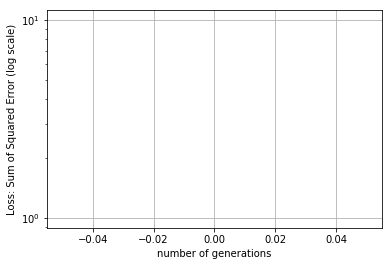

[[7.77819722e-02 9.90842068e-02 1.79718560e+01 1.11540569e+01
  3.79475946e+00 4.59554537e+01 4.29325999e+01 7.76972954e-01
  8.01879433e+01 4.97008681e+01 2.04648759e+02 8.56832404e+00
  8.73834203e+00 1.95187455e+00 1.48859540e+01 2.82688934e-01
  7.67458790e+02 6.83286592e+01 1.17836159e+01 2.82502924e+01]]


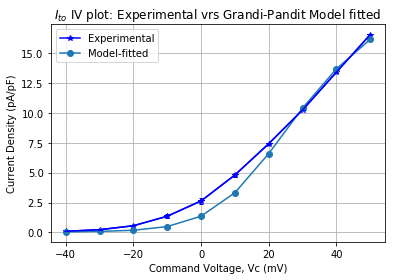

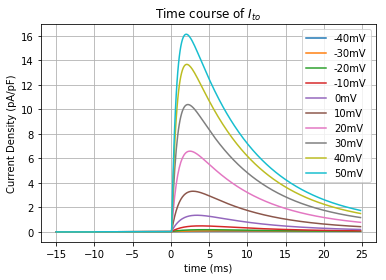

generation:  1
2
[ 64 144]
64
2.726579081014703
40
generation:  2
2
[118 198]
118
1.4961300569276679
40
generation:  3
2
[ 93 173]
93
1.2031569955665424
40
generation:  4
2
[ 84 164]
84
0.7887668625407549
40
generation:  5
2
[116 196]
116
0.7010430713409181
40
generation:  6
2
[ 70 150]
70
0.6245770251438162
40
generation:  7
2
[100 180]
100
0.6172974138718343
40
generation:  8
2
[ 53 133]
53
0.6095199443202395
40
generation:  9
2
[ 80 160]
80
0.5938241166382532
40
generation:  10
2
[ 76 156]
76
0.5891012842762607
40
Runtime:  8.619887493333332 mins


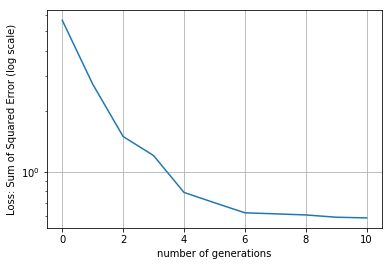

[[ 7.77819722e-02  9.90842068e-02  1.67241037e+01  1.42613014e+01
   4.35364134e+00  4.59554537e+01 -6.94638683e+00  7.76972954e-01
   8.50756032e+01  4.97008681e+01  1.69152717e+02  9.24997241e+00
   8.73834203e+00  1.95187455e+00  1.48859540e+01  2.82688934e-01
   7.60369143e+02  6.83286592e+01  1.17836159e+01  2.82502924e+01]]


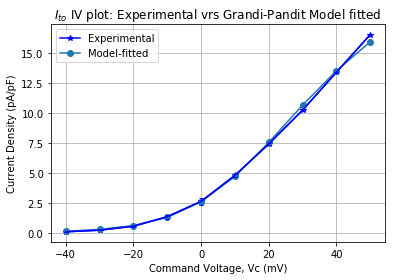

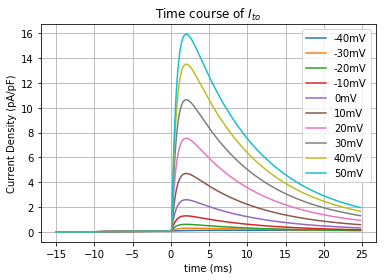

generation:  11
2
[114 194]
114
0.5779993490944055
40
generation:  12
2
[104 184]
104
0.5739340720530106
40
generation:  13
2
[ 83 163]
83
0.5250405871530937
40
generation:  14
2
[ 40 120]
40
0.4781994941793981
40
generation:  15
2
[ 42 122]
42
0.4594917673445078
40
generation:  16
2
[ 92 172]
92
0.45397600800052185
40
generation:  17
2
[ 45 125]
45
0.4234455125250469
40
generation:  18
2
[ 65 145]
65
0.39195501830991497
40
generation:  19
2
[102 182]
102
0.36869713720556796
40
generation:  20
2
[ 86 166]
86
0.3466796828913944
40
Runtime:  16.550369438333334 mins


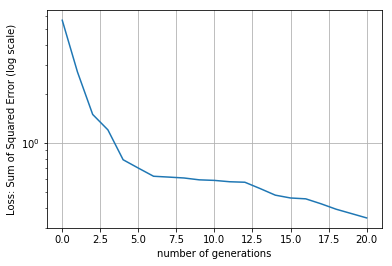

[[ 8.00629356e-02  1.00059248e-01  1.79742051e+01  1.51009276e+01
   3.79475946e+00  4.59554537e+01 -6.94638683e+00  7.50709893e-01
   7.55860730e+01  4.97008681e+01  1.69152717e+02  7.42627317e+00
   8.73834203e+00  1.95187455e+00  1.48859540e+01  2.82688934e-01
   7.60369143e+02  6.83286592e+01  1.17836159e+01  2.82502924e+01]]


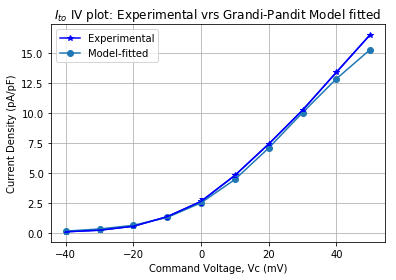

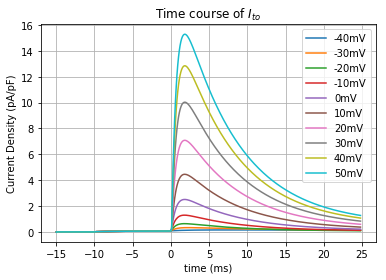

generation:  21
2
[ 71 151]
71
0.33632686399272943
40
generation:  22
2
[117 197]
117
0.3306331229054849
40
generation:  23
2
[ 43 123]
43
0.3280030880614653
40
generation:  24
2
[ 49 129]
49
0.32043810153355273
40
generation:  25


C:\Users\tetteh\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: overflow encountered in true_divide
C:\Users\tetteh\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: overflow encountered in true_divide


2
[ 79 159]
79
0.3002283179548555
40
generation:  26
2
[117 197]
117
0.2918877788397535
40
generation:  27


C:\Users\tetteh\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:85: RuntimeWarning: invalid value encountered in add
C:\Users\tetteh\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:87: RuntimeWarning: invalid value encountered in add


2
[108 188]
108
0.2878181685294374
40
generation:  28
2
[116 196]
116
0.28479914619008573
40
generation:  29
2
[ 61 141]
61
0.2845619533458559
40
generation:  30
2
[ 55 135]
55
0.28303184734833486
40
Runtime:  24.782156665000002 mins


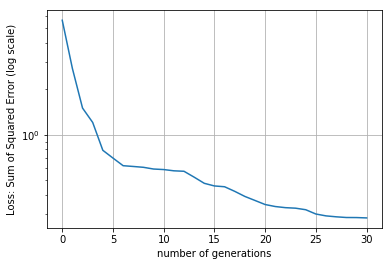

[[ 8.05666917e-02  1.00059248e-01  1.83416988e+01  1.51190223e+01
   3.79475946e+00  3.76618155e+01 -1.37922711e+01  7.50709893e-01
   8.54969414e+01  4.97008681e+01  1.09718657e+02  9.84001356e+00
   8.73834203e+00  1.95187455e+00  1.48859540e+01  2.82688934e-01
   7.60369143e+02  6.65103237e+01  1.17836159e+01  2.82502924e+01]]


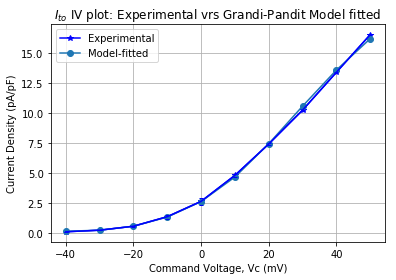

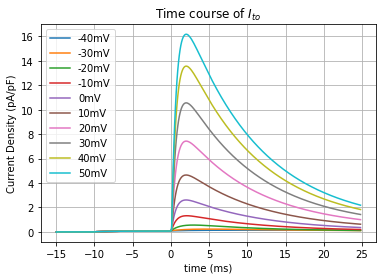

generation:  31
2
[ 76 156]
76
0.27690303263421734
40
generation:  32
2
[ 91 171]
91
0.273156740739653
40
generation:  33
2
[105 185]
105
0.2705835749070586
40
generation:  34
2
[ 95 175]
95
0.2697419054705186
40
generation:  35
2
[118 198]
118
0.2691845355141017
40
generation:  36
2
[ 95 175]
95
0.26413089914387006
40
generation:  37
2
[105 185]
105
0.23121877302206928
40
generation:  38
2
[ 60 140]
60
0.22590372087820543
40
generation:  39
2
[ 73 153]
73
0.22579032556284945
40
generation:  40
2
[ 48 128]
48
0.22230615633965783
40
Runtime:  33.037559771666665 mins


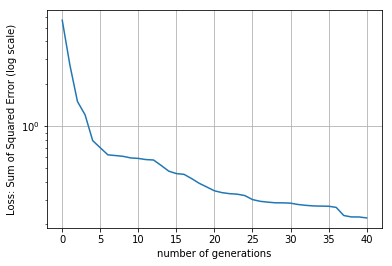

[[ 8.05666917e-02  1.01506803e-01  1.88178445e+01  1.56548559e+01
   4.34900836e+00  3.76618155e+01 -1.37922711e+01  7.50709893e-01
   7.73998057e+01  5.20621893e+01  1.09718657e+02  1.01340674e+01
   8.73834203e+00  1.95187455e+00  1.48859540e+01  2.82688934e-01
   7.53250123e+02  6.83286592e+01  1.17836159e+01  2.82502924e+01]]


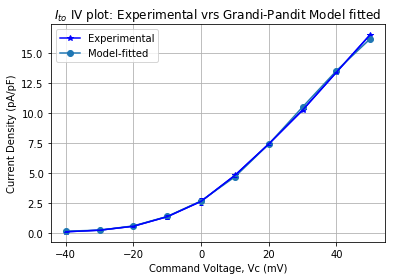

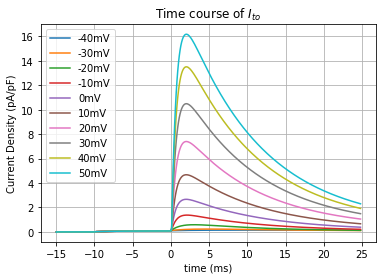

generation:  41
2
[ 95 175]
95
0.21923060603826813
40
generation:  42
2
[ 71 151]
71
0.21780706342363249
40
generation:  43
2
[ 88 168]
88
0.21622879181846216
40
generation:  44
2
[ 85 165]
85
0.21615998755130683
40
generation:  45
2
[108 188]
108
0.21329298664254334
40
generation:  46
2
[ 97 177]
97
0.19907773859150296
40
generation:  47
2
[109 189]
109
0.18451700246490377
40
generation:  48
2
[ 42 122]
42
0.18346723961015132
40
generation:  49
2
[102 182]
102
0.18312779732024162
40
generation:  50
2
[ 55 135]
55
0.1824368163701682
40
Runtime:  41.298770174999994 mins


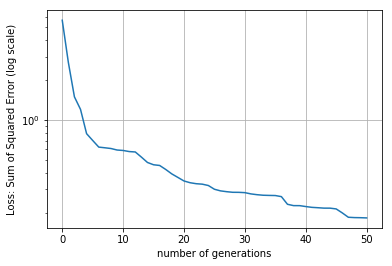

[[ 8.68579757e-02  1.01506803e-01  1.91715934e+01  1.59416350e+01
   5.75396699e+00  3.67259970e+01 -1.37922711e+01  7.50709893e-01
   9.16757574e+01  5.20621893e+01  4.84319386e+01  1.01340674e+01
   8.73834203e+00  1.95187455e+00  1.48859540e+01  2.82688934e-01
   7.60369143e+02  6.83286592e+01  1.17836159e+01  2.82502924e+01]]


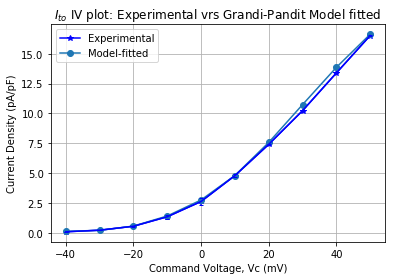

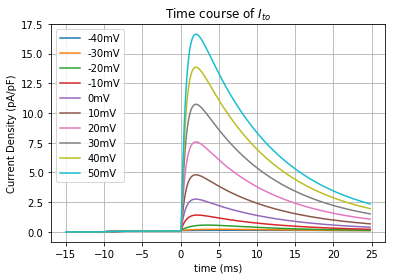

generation:  51
2
[113 193]
113
0.18182207233824393
40
generation:  52
2
[ 59 139]
59
0.18166037791668285
40
generation:  53
2
[101 181]
101
0.17852946198340136
40
generation:  54
2
[ 69 149]
69
0.17786423273802865
40
generation:  55
2
[104 184]
104
0.17584298293175438
40
generation:  56
2
[ 67 147]
67
0.17123903620603342
40
generation:  57
2
[110 190]
110
0.1667917555276201
40
generation:  58
2
[ 71 151]
71
0.1663494924005315
40
generation:  59
2
[ 62 142]
62
0.16607158426293717
40
generation:  60
2
[ 65 145]
65
0.1657645592701675
40
Runtime:  49.762602056666665 mins


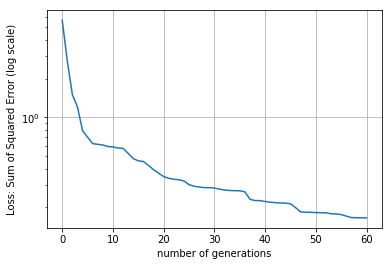

[[ 8.22056914e-02  1.01506803e-01  1.94066257e+01  1.59416350e+01
   5.35290904e+00  3.67259970e+01 -1.44830721e+01  7.43616235e-01
   1.14035360e+02  5.20621893e+01  3.29946145e+01  1.01340674e+01
   8.87619842e+00  1.95187455e+00  1.48859540e+01  2.82688934e-01
   7.60369143e+02  6.83286592e+01  1.17836159e+01  2.82502924e+01]]


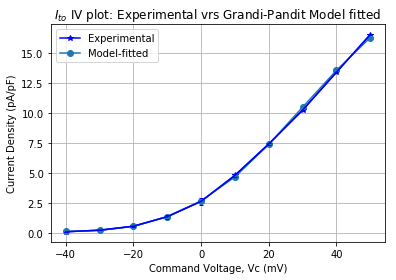

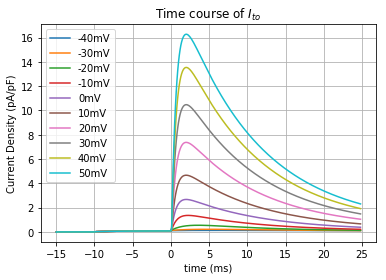

generation:  61
2
[ 61 141]
61
0.16572773666339893
40
generation:  62
2
[105 185]
105
0.16571238060766053
40
generation:  63
2
[109 189]
109
0.1656862602055918
40
generation:  64
116
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  41  44  47  49  52  53  55  57  58  61  63  64  65  66
  69  71  74  76  77  78  80  82  83  85  88  89  91  94  95  96 102 105
 110 111 112 114 117 119 121 124 127 129 132 133 135 137 138 141 143 144
 145 146 149 151 154 156 157 158 160 162 163 165 168 169 171 174 175 176
 182 185 190 191 192 194 197 199]
0
0.1656862602055918
40
generation:  65
2
[ 91 171]
91
0.1656714543875098
40
generation:  66
2
[ 84 164]
84
0.16411758815339353
40
generation:  67
2
[ 76 156]
76
0.16364687956746476
40
generation:  68
2
[114 194]
114
0.1635716980123462
40
generation:  69
2
[ 61 141]
61
0.16357049659609862
40
generation:  70
2
[ 82 162]
82
0.1635150254463836
40

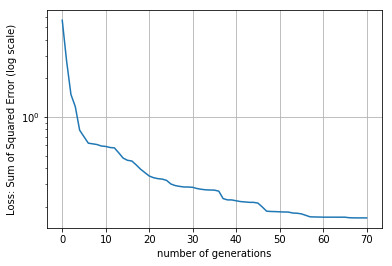

[[ 8.22056914e-02  1.01506803e-01  1.94066257e+01  1.60063827e+01
   5.17432749e+00  3.60918403e+01 -1.44830721e+01  7.43616235e-01
   1.33020292e+02  5.20621893e+01  3.01229528e+01  1.01340674e+01
   8.73834203e+00  1.95187455e+00  1.48859540e+01  2.82688934e-01
   7.60369143e+02  6.83286592e+01  1.17836159e+01  2.82502924e+01]]


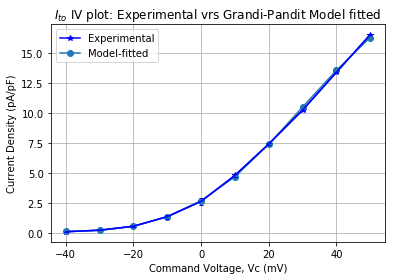

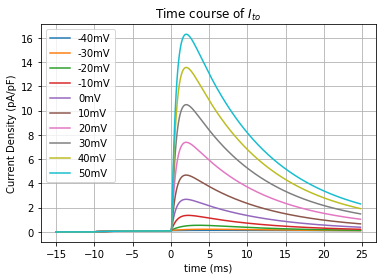

generation:  71
112
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  46  48  53  54  56  60  62  65  67  68  71  74  78
  81  84  85  86  87  88  89  91  93  95  96 101 103 106 107 109 110 111
 112 113 114 117 120 126 128 133 134 136 140 142 145 147 148 151 154 158
 161 164 165 166 167 168 169 171 173 175 176 181 183 186 187 189 190 191
 192 193 194 197]
0
0.1635150254463836
40
generation:  72
2
[119 199]
119
0.16282623786168873
40
generation:  73
2
[ 53 133]
53
0.1628056450848774
40
generation:  74
2
[ 98 178]
98
0.16275012961702406
40
generation:  75
2
[ 65 145]
65
0.16273055191578958
40
generation:  76
2
[ 89 169]
89
0.16202187654622854
40
generation:  77
2
[ 63 143]
63
0.16200653261235376
40
generation:  78
2
[109 189]
109
0.15963749323137152
40
generation:  79
2
[ 76 156]
76
0.15215579008871158
40
generation:  80
2
[118 198]
118
0.15134922252812022
40
Runtime:  65

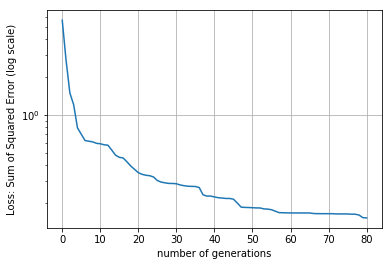

[[ 8.26644375e-02  1.01506803e-01  1.96557837e+01  1.60356121e+01
   5.17432749e+00  3.60918403e+01 -1.44830721e+01  7.43616235e-01
   1.49796727e+02  5.20621893e+01  2.87388242e+01  1.01340674e+01
   8.73834203e+00  1.95187455e+00  1.48859540e+01  2.82688934e-01
   7.60369143e+02  6.83286592e+01  1.17836159e+01  2.82502924e+01]]


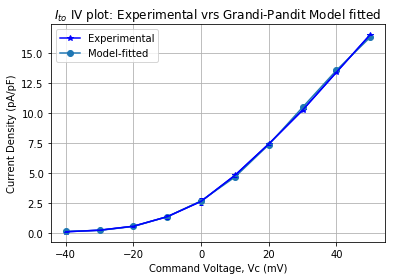

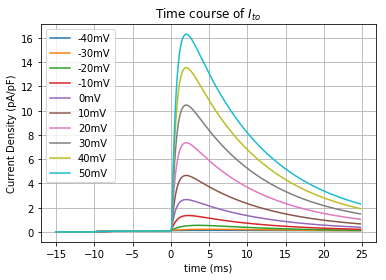

generation:  81
2
[112 192]
112
0.15113448245062636
40
generation:  82
2
[ 84 164]
84
0.15103513082670988
40
generation:  83
2
[ 78 158]
78
0.15103359594811605
40
generation:  84
2
[ 81 161]
81
0.1510204740105478
40
generation:  85
2
[ 94 174]
94
0.14894377462556319
40
generation:  86
2
[ 78 158]
78
0.14721585920294689
40
generation:  87
2
[ 79 159]
79
0.14641112680385424
40
generation:  88
2
[ 51 131]
51
0.14551451907779464
40
generation:  89
2
[102 182]
102
0.14275393997543612
40
generation:  90
2
[ 55 135]
55
0.14136481311598886
40
Runtime:  73.91113547500001 mins


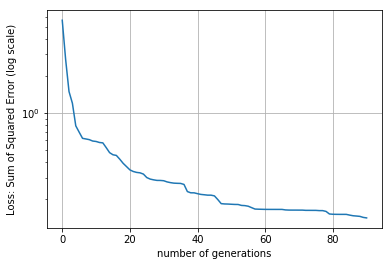

[[ 8.28196903e-02  1.01506803e-01  1.97817972e+01  1.62151861e+01
   5.48032447e+00  3.60918403e+01 -1.44830721e+01  7.43616235e-01
   1.54393405e+02  5.12351331e+01  2.87388242e+01  1.01340674e+01
   8.73834203e+00  1.95187455e+00  1.48859540e+01  2.82688934e-01
   7.60369143e+02  6.63891061e+01  1.17836159e+01  2.82502924e+01]]


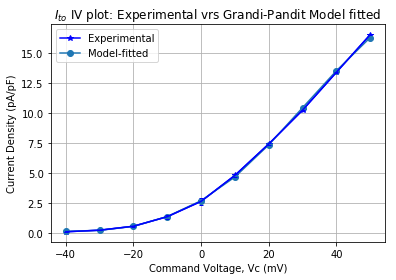

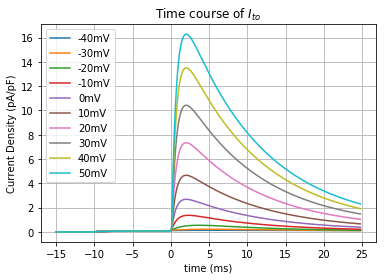

generation:  91
2
[ 48 128]
48
0.14078202182875676
40
generation:  92
2
[ 53 133]
53
0.1406702494207695
40
generation:  93
2
[110 190]
110
0.14000674468831725
40
generation:  94
2
[ 70 150]
70
0.13964725908868128
40
generation:  95
2
[ 99 179]
99
0.13958092708038713
40
generation:  96
2
[109 189]
109
0.13891050169168007
40
generation:  97
2
[ 88 168]
88
0.1385852304754298
40
generation:  98
2
[ 56 136]
56
0.13822291026233058
40
generation:  99
2
[ 56 136]
56
0.1377204990205321
40
generation:  100
2
[ 75 155]
75
0.13682707877844733
40
Runtime:  82.08436159166668 mins


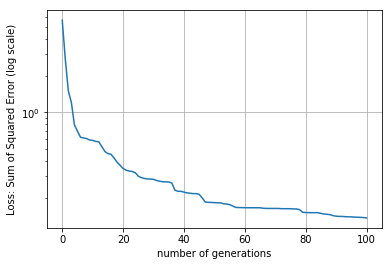

[[ 8.28196903e-02  1.01506803e-01  1.98014876e+01  1.63246242e+01
   5.48032447e+00  3.60918403e+01 -1.44830721e+01  7.43616235e-01
   1.92433104e+02  5.01814371e+01  1.02671768e+01  1.01340674e+01
   8.73834203e+00  1.95187455e+00  1.48859540e+01  2.82688934e-01
   7.60369143e+02  6.83286592e+01  1.17836159e+01  2.84432346e+01]]


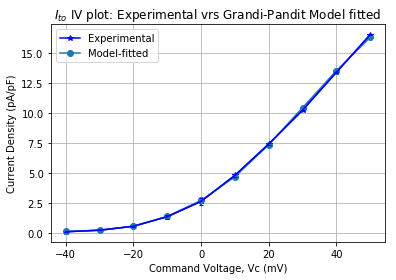

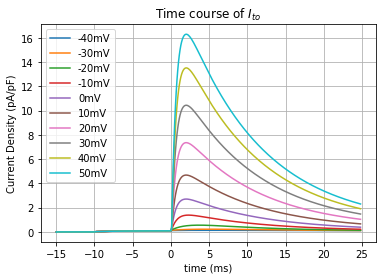

generation:  101
2
[ 90 170]
90
0.13641212211255394
40
generation:  102
2
[ 99 179]
99
0.13605398173988814
40
generation:  103
2
[ 84 164]
84
0.13586515643030933
40
generation:  104
2
[ 66 146]
66
0.1358025017740519
40
generation:  105
2
[100 180]
100
0.13562174107779165
40
generation:  106
2
[ 48 128]
48
0.13561806062163761
40
generation:  107
2
[ 97 177]
97
0.13561060496058924
40
generation:  108
108
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  43  52  54  56  57  59  60  62  72  73  76  77
  82  83  86  88  90  91  92  95  99 104 105 107 108 110 112 114 116 117
 118 119 120 121 123 132 134 136 137 139 140 142 152 153 156 157 162 163
 166 168 170 171 172 175 179 184 185 187 188 190 192 194 196 197 198 199]
0
0.13561060496058924
40
generation:  109
114
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26

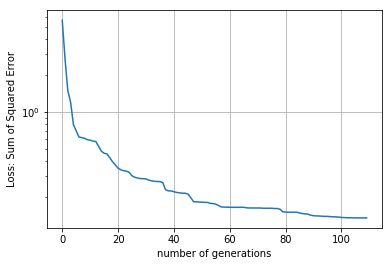

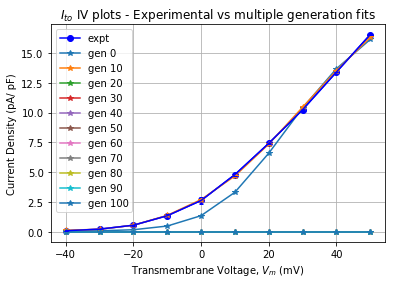

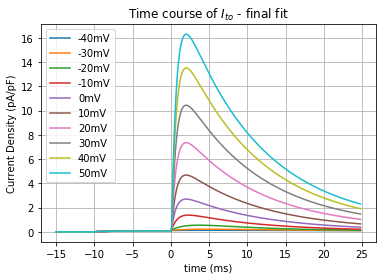

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import timeit

timer_start = timeit.default_timer()
# inputs, x
V = np.arange(-40, 51, 10)    # mV, Command Voltage

# actual Y
Ito_act = np.array(
    [0.099409446, 0.231767945, 0.562416217, 1.356413635, 2.633327121, 4.797965012, 7.412658668, 10.23024459,
     13.38482092, 16.51873419])
Ito_err = np.array([0.011391257, 0.006720079, 0.026371109, 0.152178369, 0.262996531, 0.14855301, 0.058495101,
                    0.036813974, 0.030923715, 0.038889919])

# Population
# Parameter initialization
C = np.empty((200, 20))
C[:, 0] = np.random.uniform(0, 0.1, C.shape[0])     #gtof
C[:, 1] = np.random.uniform(0, 0.1, C.shape[0])     #gtos

C[:, 2] = np.random.uniform(15.0, 25.0, C.shape[0]) #xa
C[:, 3] = np.random.uniform(8, 15, C.shape[0])     #xb
C[:, 4] = np.random.uniform(3.5, 12.5, C.shape[0])         #txaf
C[:, 5] = np.random.uniform(40, 50, C.shape[0])      #txbf
C[:, 6] = np.random.uniform(40, 60, C.shape[0])         #txcf
C[:, 7] = np.random.uniform(0, 2, C.shape[0])      #txdf
C[:, 8] = np.random.uniform(70, 95, C.shape[0])         #tyaf
C[:, 9] = np.random.uniform(30, 50, C.shape[0])       #tybf
C[:, 10] = np.random.uniform(200, 250, C.shape[0])         #tycf
C[:, 11] = np.random.uniform(5, 10, C.shape[0])          #tydf

C[:, 12] = np.random.uniform(7, 11, C.shape[0])         #txas
C[:, 13] = np.random.uniform(1, 5, C.shape[0])      #txbs
C[:, 14] = np.random.uniform(13, 17, C.shape[0])         #txcs
C[:, 15] = np.random.uniform(0, 1, C.shape[0])      #txds
C[:, 16] = np.random.uniform(750, 850, C.shape[0])         #tyas
C[:, 17] = np.random.uniform(50, 70, C.shape[0])       #tybs
C[:, 18] = np.random.uniform(8, 12, C.shape[0])         #tycs
C[:, 19] = np.random.uniform(25, 35, C.shape[0])          #tyds


##population = np.transpose(C)

Ito = np.empty((C.shape[0], len(V)))
population = C  # initial Population

# fitness
def pop_fitness(ppln):
    for i in range(C.shape[0]):
        Ito[i,:], time, plt_Ito = Ito_func(ppln[i, 0], ppln[i, 1], ppln[i, 2], ppln[i, 3], ppln[i, 4],
                                 ppln[i, 5], ppln[i, 6], ppln[i, 7], ppln[i, 8], ppln[i, 9],
                                 ppln[i, 10], ppln[i, 11], ppln[i, 12],  ppln[i, 13], ppln[i, 14],
                                 ppln[i, 15], ppln[i, 16], ppln[i, 17], ppln[i, 18], ppln[i, 19])
    SSE = np.sum((Ito - Ito_act) ** 2, axis=1)
    return SSE


def select_mating_pool(popn, fitness, num_parents):
    parents = np.empty((num_parents, popn.shape[1]))
    for parent_no in range(num_parents):
        max_fit_idx = np.where(fitness == np.min(fitness))  # find max and return its index
        max_fit_idx = max_fit_idx[0][0]  # Select the first index if repetitive
        parents[parent_no, :] = popn[max_fit_idx, :]
        fitness[max_fit_idx] = +99999999999
    return parents


# 2-point crossover
def crossover(parents,
              offspring_size):  # in the case offspring size = (k, 3) where k is the number of desired offsprings
    offspring = np.empty(offspring_size)
    #pt1 = np.random.randint(1, offspring_size[1]/2)  # randomize the crossover point, typically the middle is chosen
    #pt2
    #crossover_point1 = np.uint8(offspring_size[1] / pt)
    crossover_point1 = np.uint8(np.random.randint(1, offspring_size[1]/2))
    crossover_point2 = np.uint8(np.random.randint(offspring_size[1]/2, offspring_size[1]))

    for n in range(parents.shape[0]):
        # parent selection
        parent1_idx = n % parents.shape[0]  # using modulus helps implement a ring parent selection fashion
        parent2_idx = (n + 1) % parents.shape[0]
        # offspring will have a up to the crossover point proportion from parent1 and parent2 respectively
        # Actual crossover
        # todo: generate two offsprings instead of one
        offspring[n, 0:crossover_point1] = parents[parent1_idx, 0:crossover_point1]
        offspring[n, crossover_point1:crossover_point2] = parents[parent2_idx, crossover_point1:crossover_point2]
        offspring[n, crossover_point2:] = parents[parent1_idx, crossover_point2:]
        #second offspring
        offspring[n + parents.shape[0], 0:crossover_point1] = parents[parent1_idx, 0:crossover_point1]
        offspring[n + parents.shape[0], crossover_point1:]  = parents[parent2_idx, crossover_point1:]
        
    return offspring

def mutation(offspring_crossover):
    # single gene random change per offspring
    for idx in range(offspring_crossover.shape[0]):
        gene_select = np.random.randint(0, population.shape[1])  # vary range of random value for gene variation
        rand_mutn_val =( (gene_select == 0)*np.random.uniform(-0.01, 0.01) +    #gtof
                         (gene_select == 1)*np.random.uniform(-0.01, 0.01) +    #gtos
                        
                         (gene_select == 2)*np.random.uniform(-2, 2) +      #xa
                         (gene_select == 3)*np.random.uniform(-1.5, 1.5) +          #xb

                         (gene_select == 4)*np.random.uniform(-1.5, 1.5) +          #txaf
                         (gene_select == 5)*np.random.uniform(-5.0, 5.0) +      #txbf
                         (gene_select == 6)*np.random.uniform(-50.0, 50.0) +      #txcf
                         (gene_select == 7)*np.random.uniform(-2, 2) +          #txdf
                         (gene_select == 8)*np.random.uniform(-10, 10) +      #tyaf
                         (gene_select == 9)*np.random.uniform(-20, 20) +       #tybf
                         (gene_select == 10)*np.random.uniform(-50, 50) +         #tycf
                         (gene_select == 11)*np.random.uniform(-3, 3)   +   #tydf
                        
                         (gene_select == 12)*np.random.uniform(-2, 2) +          #txas
                         (gene_select == 13)*np.random.uniform(-1, 1) +      #txbs
                         (gene_select == 14)*np.random.uniform(-2, 2) +      #txcs
                         (gene_select == 15)*np.random.uniform(-0.1, 0.1) +          #txds
                         (gene_select == 16)*np.random.uniform(-10, 10) +      #tyas
                         (gene_select == 17)*np.random.uniform(-5, 5) +       #tybs
                         (gene_select == 18)*np.random.uniform(-2, 2) +         #tycs
                         (gene_select == 19)*np.random.uniform(-3, 3)        #tyds
                         )
        # todo: try mutating some offsprings and not all
        offspring_crossover[idx, gene_select] = offspring_crossover[idx, gene_select] + rand_mutn_val
    return offspring_crossover

i_plt = 0
gen_mod = 10
num_of_gens = 110
no_plts = num_of_gens/gen_mod
no_plts = np.int16(no_plts)
gen_curr_arr = np.zeros((10, num_of_gens))
num_mating_parents = int(C.shape[0]/5)
best_gen_fitness = []
for generation in range(num_of_gens):
    print('generation: ', generation)
    fitness = pop_fitness(population)  # calculate fitness (SSE)
    #print(fitness)
    fitness = np.where(np.isnan(fitness), 1e12, fitness) #handles the dreaded nan's
    #fitness = np.where(np.isinf(fitness), 0, fitness)
    best_gn_fit_idx = np.where(fitness == np.min(fitness))
    print(best_gn_fit_idx[0].size)
    print(best_gn_fit_idx[0])
    if best_gn_fit_idx[0].size == 0:
        indx = np.random.randint(0, C.shape[0])
    else:
        indx = best_gn_fit_idx[0][0]
        
    print(indx)
    print(fitness[indx])
    best_gen_fitness.append(fitness[indx])
    parents = select_mating_pool(population, fitness, num_mating_parents)  # choose mating parents based on best min SSE
    print(parents.shape[0])
    offspring_crossed = crossover(parents, offspring_size=(2*parents.shape[0], population.shape[1]))
    offspring_mutated = mutation(offspring_crossed)
    # assumption in the above 3 lines, the number of parents, offsprings and mutants are same
    # create new population with parents, offsprings and their mutants
    population[0:parents.shape[0], :] = parents
    population[parents.shape[0]: 3 * parents.shape[0], :] = offspring_crossed
    population[3 * parents.shape[0]:, :] = offspring_mutated

    if generation%gen_mod == 0:
        best_gn_fit_idx = np.where(fitness == np.min(fitness))
        b_idx = best_gn_fit_idx
        gen_num = np.arange(len(best_gen_fitness))
        timer_stop = timeit.default_timer()
        print('Runtime: ', (timer_stop - timer_start)/60.0, 'mins')
        plt.plot(gen_num, best_gen_fitness)
        plt.xlabel('number of generations')
        plt.ylabel('Loss: Sum of Squared Error (log scale)')
        plt.yscale('log')
        plt.grid()
        plt.show()
        y_fit, time_fit, plt_Ito_fit = Ito_func(population[b_idx, 0], population[b_idx, 1], population[b_idx, 2],
                               population[b_idx, 3], population[b_idx, 4], population[b_idx, 5],
                               population[b_idx, 6], population[b_idx, 7], population[b_idx, 8],
                              population[b_idx, 9], population[b_idx, 10], population[b_idx, 11],
                              population[b_idx, 12], population[b_idx, 13], population[b_idx, 14], 
                                population[b_idx, 15],population[b_idx, 16], population[b_idx, 17],
                                 population[b_idx, 18], population[b_idx, 19])
        gen_curr_arr[:, i_plt] = y_fit
        print(population[[best_gn_fit_idx][0][0], :])
        plt.figure()
        plt.plot(V, Ito_act, 'b-*', V, y_fit, '-o')
        plt.errorbar(V, Ito_act, yerr=Ito_err, capsize=2, color = 'blue')
        plt.legend(['Experimental', 'Model-fitted'], loc='best')
        plt.xlabel('Command Voltage, Vc (mV)')
        plt.ylabel('Current Density (pA/pF)')
        plt.title('$I_{to}$ IV plot: Experimental vrs Grandi-Pandit Model fitted')
        plt.grid()
        plt.show()
        
        plt.figure()
        plt.plot(time_fit, plt_Ito_fit)
        plt.xlabel('time (ms)')
        plt.ylabel('Current Density (pA/pF)')
        plt.title('Time course of $I_{to}$')
        plt.legend(['-40mV', '-30mV', '-20mV', '-10mV', '0mV', '10mV', '20mV', '30mV', '40mV', '50mV'], loc='best')
        plt.grid()
        plt.show()
        i_plt = i_plt + 1

#find the final optimized parameters - chromosomes
fitness = pop_fitness(population)
best_match_idx = np.where(fitness == np.min(fitness))
print("Best Solution: ", population[best_match_idx[0][0], :])
print("Best solution fitness: ", fitness[best_match_idx[0][0]])

gen_num = np.arange(len(best_gen_fitness))
plt.figure()
plt.plot(gen_num, best_gen_fitness)
plt.yscale('log')
plt.xlabel('number of generations')
plt.ylabel('Loss: Sum of Squared Error')
plt.grid()
plt.show()

plt.figure()
plt.plot(V, Ito_act, 'b-o', label = 'expt')
for cnt in np.arange(0,gen_curr_arr.shape[1], gen_mod):
    plt.plot(V, gen_curr_arr[:, cnt], '-*', label='gen %s' %(cnt))

plt.xlabel('Transmembrane Voltage, $V_m$ (mV)')
plt.ylabel('Current Density (pA/ pF)')
plt.title('$I_{to}$ IV plots - Experimental vs multiple generation fits')
plt.grid()
plt.legend(loc='best')
plt.errorbar(V, Ito_act, yerr=Ito_err, capsize=2, color = 'blue')
plt.show()

plt.figure()
plt.plot(time_fit, plt_Ito_fit)
plt.xlabel('time (ms)')
plt.ylabel('Current Density (pA/pF)')
plt.title('Time course of $I_{to}$ - final fit')
plt.legend(['-40mV', '-30mV', '-20mV', '-10mV', '0mV', '10mV', '20mV', '30mV', '40mV', '50mV'], loc='best')
plt.grid()
plt.show()


Initial Model Goodness of fit, R_sq = -0.33464224925180686
GA fitted Model Goodness of fit, R_sq = 0.9995674142008156
percent change: [ 5.81569216e+03  1.69964902e+02  4.21835579e+00  2.55740323e+01
 -3.55255945e+01 -1.97959104e+01 -1.28966144e+02  4.87232470e+01
  1.26391887e+02  2.54535927e+01 -9.53331015e+01  4.47723914e+01
 -2.90731078e+00 -3.49375150e+01 -7.60306667e-01 -4.34622132e+01
 -4.95385712e+00  1.38810987e+01  1.78361590e+01 -9.06436728e+01]


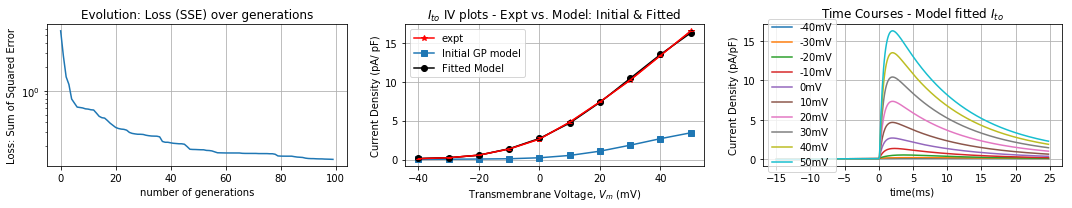

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

#initial model
ItoIni, time, ItoIni_time = Ito_func(0.0014, 0.0376, 19, 13, 8.5, 45, 50, 0.5, 85, 40, 220, 7, 9, 3, 15, 0.5, 800, 60, 10, 30)

#fitted model
Itofit, time, Itofit_time  = Ito_func(8.28196903e-02,  1.01506803e-01,  1.98014876e+01,  1.63246242e+01,
   5.48032447e+00,  3.60918403e+01, -1.44830721e+01,  7.43616235e-01,
   1.92433104e+02,  5.01814371e+01,  1.02671768e+01,  1.01340674e+01,
   8.73834203e+00,  1.95187455e+00,  1.48859540e+01,  2.82688934e-01,
   7.60369143e+02,  6.83286592e+01,  1.17836159e+01,  2.84432346e+01)
Ito_act = np.array(
    [0.099409446, 0.231767945, 0.562416217, 1.356413635, 2.633327121, 4.797965012, 7.412658668, 10.23024459,
     13.38482092, 16.51873419])
Ito_err = np.array([0.011391257, 0.006720079, 0.026371109, 0.152178369, 0.262996531, 0.14855301, 0.058495101,
                    0.036813974, 0.030923715, 0.038889919])

Vcm = np.arange(-40, 51, 10)

ini_r2 = r2_score(Ito_act, ItoIni)
fit_r2 = r2_score(Ito_act, Itofit)

print('Initial Model Goodness of fit, R_sq = %s' %ini_r2)
print('GA fitted Model Goodness of fit, R_sq = %s' %fit_r2)

ini_param = np.array([0.0014, 0.0376, 19, 13, 8.5, 45, 50, 0.5, 85, 40, 220, 7, 9, 3, 15, 0.5, 800, 60, 10, 304])
fin_param = np.array([8.28196903e-02,  1.01506803e-01,  1.98014876e+01,  1.63246242e+01,
   5.48032447e+00,  3.60918403e+01, -1.44830721e+01,  7.43616235e-01,
   1.92433104e+02,  5.01814371e+01,  1.02671768e+01,  1.01340674e+01,
   8.73834203e+00,  1.95187455e+00,  1.48859540e+01,  2.82688934e-01,
   7.60369143e+02,  6.83286592e+01,  1.17836159e+01,  2.84432346e+01])
percent_change = ((fin_param - ini_param)/ini_param)*100

print('percent change:', percent_change)

plt.figure(figsize=(15,3))
plt.subplot(1,3,3)
plt.plot(time, Itofit_time)
plt.xlabel('time(ms)')
plt.ylabel('Current Density (pA/pF)')
plt.title('Time Courses - Model fitted $I_{to}$')
plt.legend(['-40mV', '-30mV', '-20mV', '-10mV', '0mV', '10mV', '20mV', '30mV', '40mV', '50mV'], loc='center left')
plt.grid()

plt.subplot(1,3,2)
plt.plot(Vcm, Ito_act, 'r-*', label = 'expt') #experimental plot
plt.plot(Vcm, ItoIni, '-s', label='Initial GP model')  #initial model plot
plt.plot(Vcm, Itofit, 'k-o', label='Fitted Model') #modelfitted
plt.errorbar(Vcm, Ito_act, yerr=Ito_err, capsize=2, color = 'red') #errorbar experimental data
plt.xlabel('Transmembrane Voltage, $V_m$ (mV)')
plt.ylabel('Current Density (pA/ pF)')
plt.title('$I_{to}$ IV plots - Expt vs. Model: Initial & Fitted')
plt.grid()
plt.legend(loc='best')

plt.subplot(1,3,1)
gen_num = np.arange(len(best_gen_fitness))
plt.plot(gen_num[:100], best_gen_fitness[:100])
plt.yscale('log')
plt.xlabel('number of generations')
plt.ylabel('Loss: Sum of Squared Error')
plt.title('Evolution: Loss (SSE) over generations')
plt.grid()
plt.tight_layout()
plt.show()
